In [17]:
using LinearAlgebra
using Plots
using Printf
using OffsetArrays
using Integrals
using StaticArrays

In [2]:
@enum FlaxMethod LaxFriedrichs Godunov #Roe # HLL HLLC
@enum BoundaryCondition Reflecting Extrapolate # Periodic
@enum SlopeLimiter Minmod VanLeer Superbee

In [3]:
a = zeros(3)
a

3-element Vector{Float64}:
 0.0
 0.0
 0.0

In [4]:
oa = OffsetArray([1, 2, 3], -1)
oa

3-element OffsetArray(::Vector{Int64}, 0:2) with eltype Int64 with indices 0:2:
 1
 2
 3

In [5]:
oa[0]

1

In [6]:
length(oa)

3

In [8]:
oa[end]

3

In [9]:
zeros((3,2))

3×2 Matrix{Float64}:
 0.0  0.0
 0.0  0.0
 0.0  0.0

In [10]:
oa = OffsetArray(Array{Float64}(undef, 3, 1), -1, -1)
oa

3×1 OffsetArray(::Matrix{Float64}, 0:2, 0:0) with eltype Float64 with indices 0:2×0:0:
 9.982837073914e-312
 9.977758496857e-312
 6.95272813387266e-310

In [11]:
oa[1]

9.982837073914e-312

In [12]:
oa = OffsetArray(Array{Float64}(undef, 3, 2), -1, -1)
oa

3×2 OffsetArray(::Matrix{Float64}, 0:2, 0:1) with eltype Float64 with indices 0:2×0:1:
   6.7786e-320     6.7786e-320
 NaN             NaN
   6.95273e-310    6.95273e-310

In [21]:
zeros(1)

1-element Vector{Float64}:
 0.0

In [23]:
n = 3
V =  [@SVector zeros(n) for i in 1:2]
V

2-element Vector{SVector{3, Float64}}:
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]

In [30]:
oav = OffsetArray(V, -1)

2-element OffsetArray(::Vector{SVector{3, Float64}}, 0:1) with eltype SVector{3, Float64} with indices 0:1:
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]

In [31]:
oav[0]

3-element SVector{3, Float64} with indices SOneTo(3):
 0.0
 0.0
 0.0

In [32]:
oav[0] = @SVector [1, 2, 3]

3-element SVector{3, Int64} with indices SOneTo(3):
 1
 2
 3

In [14]:
aV = [Vector{Float64}(undef,1) for _ in 1:10]

10-element Vector{Vector{Float64}}:
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]

In [15]:
oa = OffsetArray(V, -1)

UndefVarError: UndefVarError: `V` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [16]:
3 * oa[0]

BoundsError: BoundsError: attempt to access 3×2 Matrix{Float64} at index [0]

In [34]:
@SVector [0]

1-element SVector{1, Int64} with indices SOneTo(1):
 0

In [ ]:
function apply_boundary_condition!(q, bc, nbc)
    if bc == Reflecting
        q[0, :] = q[1, :]
        q[end, :] = q[end-1 ,:]
    elseif bc == Extrapolate
        for i in 1:nbc
            q[1-i, :] = q[1, :]
            q[end-i+1, : ] = q[end - nbc, :]
        end
    end
end


function rs(q, i, A::AbstractMatrix, dx, dt)
    dqm = q[i] - q[i-1]
    dqp = q[i+1] - q[i]

    λ, R = eigen(A)
    R_inv = inv(R)

    Ap = R * diagm(max.(λ, 0)) * R_inv
    Am = R * diagm(min.(λ, 0)) * R_inv


    return q[i] - dt/dx * (Ap * dqm + Am * dqp) 
end

function rs(q, i, A::Number, dx, dt)
    dqm = q[i] - q[i-1]
    dqp = q[i+1] - q[i]

    Ap = max(A, 0)
    Am = min(A, 0)

    return q[i] - dt/dx * (Ap * dqm + Am * dqp) 
end


function evolve(q, i, A, dt, dx, method)
   if method == LaxFriedrichs
        return (q[i-1] + q[i+1])/2  - dt/dx * ( A * q[i]  - A*q[i-1])
    elseif method == Godunov
       return rs(q, i, A, dx, dt)
    end
end

function minmod(a, b, dx)
    if a*b < 0
        return 0
    else
        return sign(a) * min(abs(a), abs(b))
    end
end

function reconstruct(q, i, slope, dx)
    if slope == Minmod
        return minmod(q[i] - q[i-1], q[i+1] - q[i], dx)
    else 
        return  q
    end
end

function solve(A, a, b, dx , dt, tmax, g_initial, method, log_interval=0)
    
    # hardcoded boundary condition for now
    # 2 ghost cells front and back
    ngc = 2

    N = Int((b-a)/dx)+1

    ndim = length(g_initial(a))
    # initiliaze grid

        
    q0 = OffsetArray( [@SVector zeros(ndim) for i in 1:(N+2*ngc)],  -ngc)
    q1 = OffsetArray( [@SVector zeros(ndim) for i in 1:(N+2*ngc)],  -ngc)

    @printf("N = %d\n", N)
    # improve later on

    for i in 1:N
        iv =  g_initial(a + (i-1)*dx)
        if isa(iv, Number)
            q0[i] = @SVector [iv]
        else
            q0[i] = iv
        end
    end



    τ = 0
    last_log = 0

    output = [q0[1:N]]

    # Linear constant coefficient problems for now
    while τ < tmax
        # boundary condition
        apply_boundary_condition!(q0, Extrapolate, ngc)

        for i in 1:N
            
            # reconstruction

            # evolution

            q1[i] = evolve(q0, i, A, dt, dx, method)
            # Averaging
            
            # todo check CFL condition

        end

        # log
        if log_interval > 0 && τ - last_log > log_interval
            push!(output, q1[1:N])
            last_log = τ
        end

        # swap states
        q0, q1 = q1, q0
   
        τ += dt
    end

    push!(output, q1[1:N])
    return output
end




solve (generic function with 2 methods)

In [63]:
g_ind(x, a, b) = if (x > a && x < b) 1 else 0 end

g_initial(x) = exp(-200*(x-0.3)^2)  + g_ind(x, 0.6, 0.8)

g_initial (generic function with 1 method)

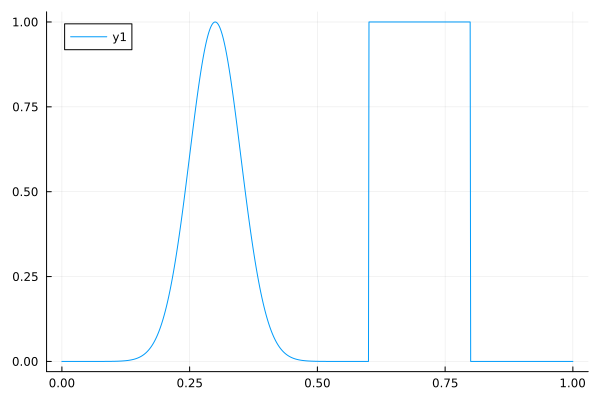

In [64]:
x = 0:0.001:1
plot(x, g_initial.(x))

In [ ]:
u = 1
a = 0
b = 2
dx = 0.01
dt = 0.001

sol = solve(u, a, b, dx , dt, 4, g_initial, Godunov, dt)

N = 201
i = 1
q0 = [1.522997974471263e-8]
q = SVector{1, Float64}[[1.522997974471263e-8], [1.522997974471263e-8], [1.522997974471263e-8], [4.956405319172498e-8], [1.549753135702902e-7], [4.655715715783078e-7], [1.343812277631519e-6], [3.726653172078671e-6], [9.929504305851081e-6], [2.541934651619929e-5], [6.252150377482037e-5], [0.0001477483602320339], [0.0003354626279025121], [0.0007318024188804728], [0.0015338106793244643], [0.0030887154082367718], [0.005976022895005953], [0.011108996538242306], [0.019841094744370305], [0.03404745473459938], [0.056134762834133725], [0.08892161745938638], [0.1353352832366128], [0.1978986990836147], [0.27803730045319425], [0.37531109885139974], [0.4867522559599717], [0.6065306597126335], [0.7261490370736912], [0.8352702114112723], [0.9231163463866361], [0.9801986733067553], [1.0], [0.9801986733067553], [0.9231163463866356], [0.8352702114112718], [0.7261490370736905], [0.6065306597126329], [0.4867522559599717], [0.3753110988513995], [0.2780373004531939]

Excessive output truncated after 525435 bytes.

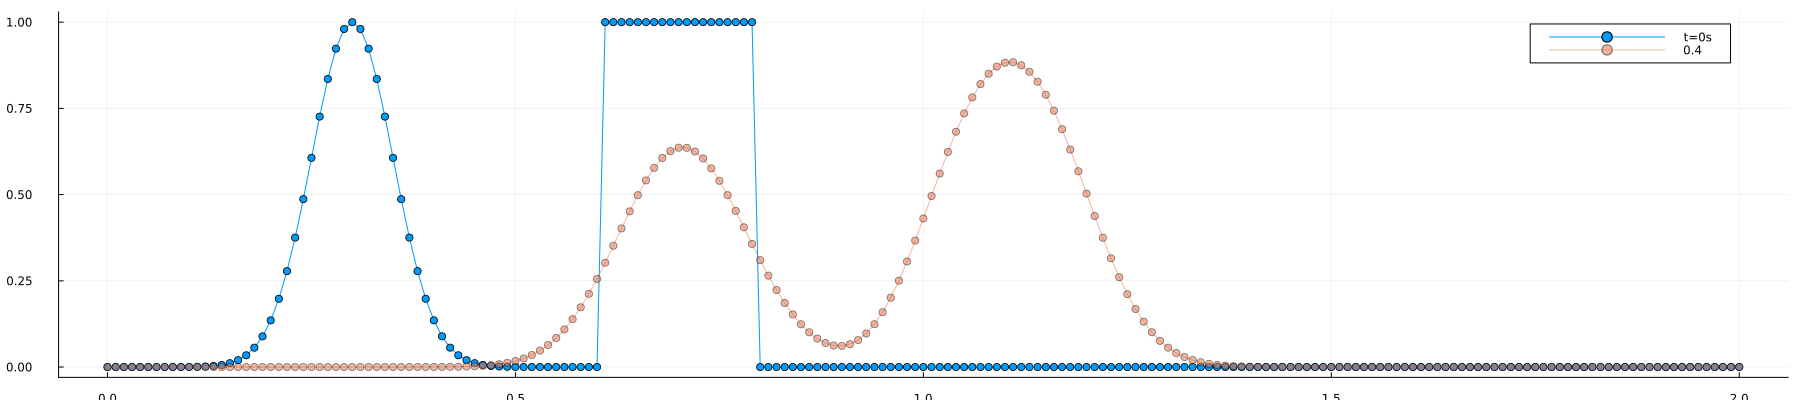

In [219]:
n = 400
t = n * dt
x = a:dx:b

plot(x, sol[1], marker=:circle, label="t=0s", size=(1800, 400))
plot!(x, sol[n], marker=:circle, label="$t", opacity=0.5)

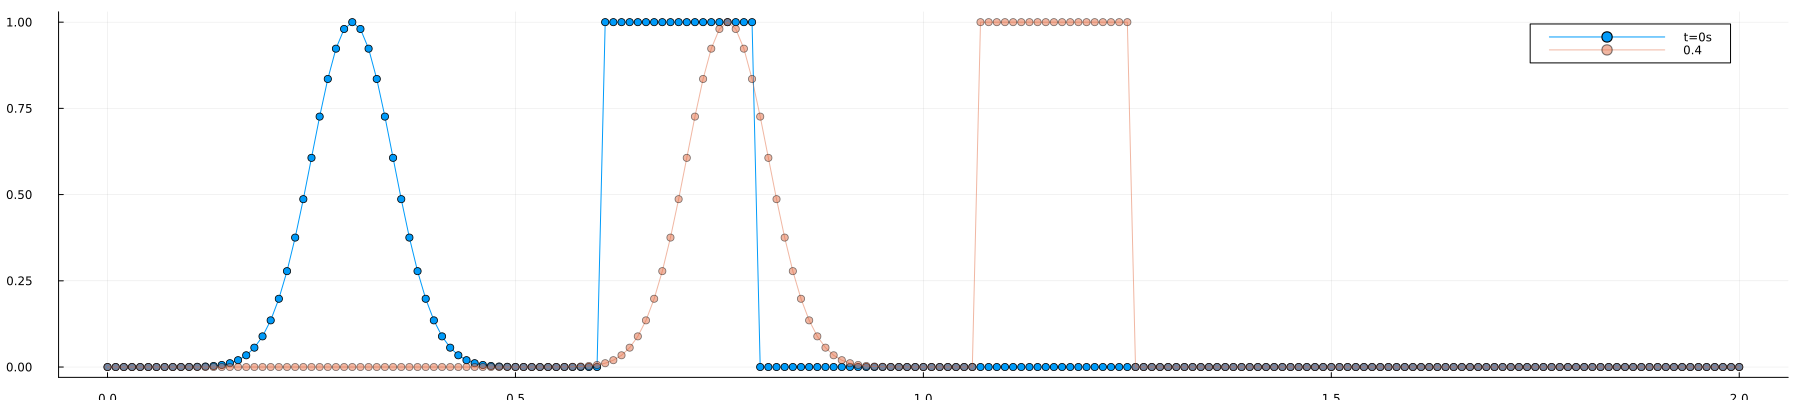

In [220]:
CFL = 1/2 

u_cfl = 1
a_cfl = 0
b_cfl = 2
dx_cfl = 0.01
dt_cfl = 0.01


n = 40
t = n * dt_cfl 

sol_cfl = solve(u_cfl, a_cfl, b_cfl, dx_cfl , dt_cfl, 4, g_initial, Godunov, dt_cfl)

plot(x, sol_cfl[1], marker=:circle, label="t=0s", size=(1800, 400))
plot!(x, sol_cfl[n], marker=:circle, label="$t", opacity=0.5)

In [221]:
p_0(x) = exp(-80*x^2)/2 + g_ind(x, -0.3, -0.1)
u_0(x) = 0 
q_0(x) = [p_0(x), u_0(x)]

q_0 (generic function with 1 method)

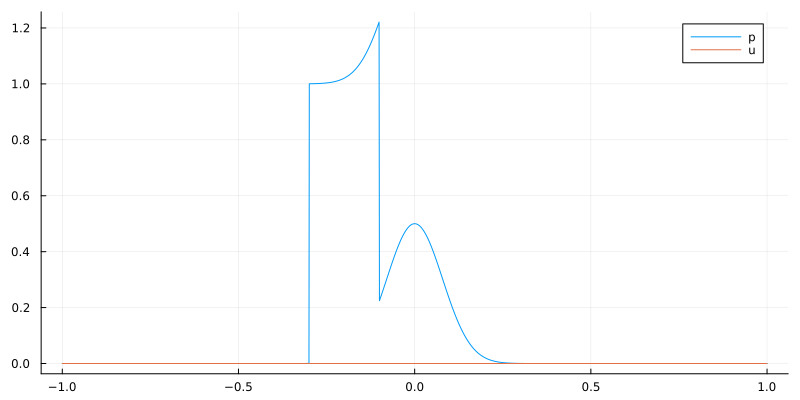

In [222]:
x = -1:0.001:1
plot(x, p_0.(x), label="p", size=(800, 400))
plot!(x, u_0.(x), label="u")

In [223]:
po = 1
Ko = 0.25

A =    [0 Ko; 1/po 0]
dx = 0.01 
dt = 0.001
tmax = 1
method = Godunov



sol_acc = solve(A, -1, 1, dx , dt, tmax, q_0, Godunov, dt_cfl)


ArgumentError: ArgumentError: offset arrays are not supported but got an array with index other than 1

In [183]:
length(q_0(0))

2

In [186]:
size(q_0(0))

(2,)

In [187]:
ndims(q_0(0))

1